# Make Gaussian Label Dataset

In [1]:
import cv2
import glob
import os
import shutil
import random
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openslide import OpenSlide
from multiprocessing import Pool

## Load annotation data

In [2]:
annotation_filepath = "MITOS_WSI_CMC/databases/MITOS_WSI_CMC_CODAEL_TR_ROI.sqlite"
WSI_dir = "MITOS_WSI_CMC/WSI"

In [3]:
DB = sqlite3.connect(annotation_filepath)
file_df = pd.read_sql('SELECT * FROM Slides', DB)
label_df = pd.read_sql('SELECT * FROM Annotations', DB)

mitosis_df = label_df[label_df["agreedClass"]==2]
print(mitosis_df)
notmitosis_df = label_df[label_df["agreedClass"]==1]
print(mitosis_df.head())
coordinates_df = pd.read_sql('SELECT * FROM Annotations_coordinates', DB)
print(coordinates_df.head())

OperationalError: unable to open database file

In [9]:
test_wsi_filenames = ["4eee7b944ad5e46c60ce.svs",
                      "e09512d530d933e436d5.svs",
                      "2d56d1902ca533a5b509.svs",
                      "13528f1921d4f1f15511.svs",
                      "69a02453620ade0edefd.svs",
                      "b1bdee8e5e3372174619.svs",
                      "022857018aa597374b6c.svs"]

wsi_list = glob.glob("{}/*.svs".format(WSI_dir))
trainval_list = []
test_list = []
for wsi_path in wsi_list:
    if wsi_path.split("/")[-1] in test_wsi_filenames:
        test_list.append(wsi_path)
    else:
        trainval_list.append(wsi_path)

## Make gaussian label

In [5]:
MULTI_NUM = 8
GAUSS_STD = 10
CROP_SIZE = 256
OVERLAP = 128

Gaussian std: 10


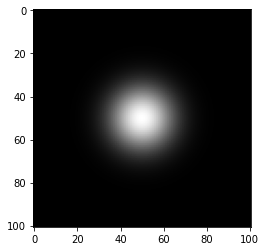

In [6]:
def gaussian2d(size, sigma):
    ax = np.linspace(-(size-1)/2, (size-1)/2, size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel

kernel = gaussian2d(size=101, sigma=GAUSS_STD)
print("Gaussian std: {}".format(GAUSS_STD))
plt.imshow(kernel, cmap="gray")

In [76]:
dataset_dirname = "gaussian_dataset"
if os.path.exists(dataset_dirname):
    shutil.rmtree(dataset_dirname)

def make_label(wsi_path, crop_size=CROP_SIZE, overlap=OVERLAP, kernel=kernel):
    filename = wsi_path.split("/")[-1]
    filedata = file_df[file_df["filename"]==filename]
    wsi_id = filedata.iat[0, 0]
    wsi = OpenSlide(wsi_path)
    wsi_w, wsi_h = wsi.dimensions
    
    if not os.path.exists("{}/{}/image".format(dataset_dirname, wsi_id)):
        os.makedirs("{}/{}/image".format(dataset_dirname, wsi_id))
    if not os.path.exists("{}/{}/label".format(dataset_dirname, wsi_id)):
        os.makedirs("{}/{}/label".format(dataset_dirname, wsi_id))
    
    print("Now processing {}".format(filename))
    
    iter_h = wsi_h//(crop_size-overlap)
    iter_w = wsi_w//(crop_size-overlap)
    
    for i in range(iter_h):
        for j in range(iter_w):
            # Coordinates of upper left of ROI
            location = (j*(crop_size-overlap), i*(crop_size-overlap))
            
            cells = coordinates_df[(coordinates_df["slide"]==wsi_id) 
                                    & (location[0] <= coordinates_df["coordinateX"])
                                    & (coordinates_df["coordinateX"] < location[0]+crop_size)
                                    & (location[1] <= coordinates_df["coordinateY"])
                                    & (coordinates_df["coordinateY"] < location[1]+crop_size)]

            label = np.zeros((crop_size, crop_size, 3), np.uint8)            

            for _, row in cells.iterrows():
                uid = int(row.annoId)
                if not mitosis_df[(mitosis_df["uid"]==uid)].empty:
                    x = row.coordinateX - location[0]
                    y = row.coordinateY - location[1]
                    for m in range(101):
                        if 0 <= int(y)-50+m < crop_size:
                            for n in range(101):
                                if 0 <= int(x)-50+n < crop_size:
                                    label[int(y)-50+m, int(x)-50+n, 0]=max(int(255*kernel[m,n]),label[int(y)-50+m, int(x)-50+n, 0])
                if not notmitosis_df[(notmitosis_df["uid"]==uid)].empty:
                    x = row.coordinateX - location[0]
                    y = row.coordinateY - location[1]
                    for m in range(101):
                        if 0 <= int(y)-50+m < crop_size:
                            for n in range(101):
                                if 0 <= int(x)-50+n < crop_size:
                                    label[int(y)-50+m, int(x)-50+n, 1]=max(int(255*kernel[m,n]),label[int(y)-50+m, int(x)-50+n, 1])
            
            # Determine the value of the third channel so that the sum of the three channels is 255.
            label[:, :, 2] = 255 - (label[:, :, 0]+label[:, :, 1])
            
            # When the object of interest is included in the image, it is stored in the dataset.
            if np.max(label[overlap//2:-(overlap//2), overlap//2:-(overlap//2), :2]==255):
                img = wsi.read_region(location, 0, (crop_size, crop_size))
                img = np.array(img, dtype=np.uint8)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                cv2.imwrite("{}/{}/image/{}_{}.png".format(dataset_dirname, wsi_id, location[0], location[1]), img)
                cv2.imwrite("{}/{}/label/{}_{}.png".format(dataset_dirname, wsi_id, location[0], location[1]), label[:,:,::-1])

p = Pool(MULTI_NUM)
p.map(make_label, trainval_list)
p.close()

Now processing 50cf88e9a33df0c0c8f9.svsNow processing a8773be388e12df89edd.svs

Now processing 2191a7aa287ce1d5dbc0.svs
Now processing da18e7b9846e9d38034c.svsNow processing d37ab62158945f22deed.svs

Now processing fa4959e484beec77543b.svsNow processing deb768e5efb9d1dcbc13.svs

Now processing b1bdee8e5e3372174619.svs
Now processing 460906c0b1fe17ea5354.svs
Now processing 72c93e042d0171a61012.svs
Now processing d0423ef9a648bb66a763.svs
Now processing 084383c18b9060880e82.svs
Now processing 3d3d04eca056556b0b26.svs
Now processing d7a8af121d7d4f3fbf01.svs
Now processing c4b95da36e32993289cb.svs


## Check dataset

39629


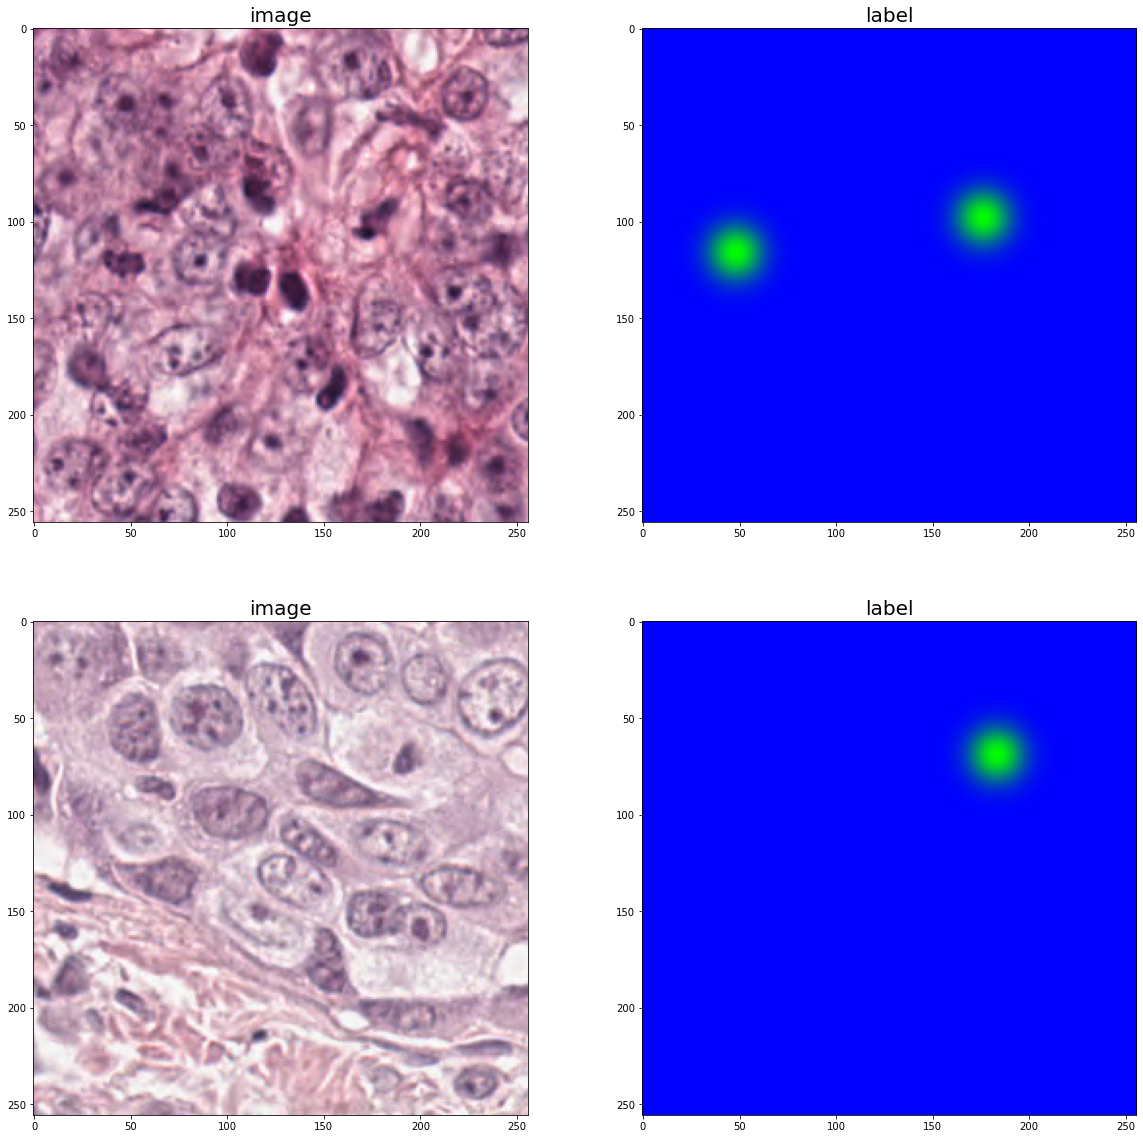

In [25]:
dataset_dirname = "gaussian_dataset"
img_list = glob.glob("{}/*/image/*".format(dataset_dirname))
label_list = glob.glob("{}/*/label/*".format(dataset_dirname))
print(len(img_list))
row_num = 2

fig, axs = plt.subplots(row_num, 2, figsize=(20, 20))

sampling = random.sample(range(len(img_list)), k=row_num)

for i in range(row_num):
    j=sampling[i]
    img = cv2.imread(img_list[j])
    label = cv2.imread(label_list[j])
    axs[i, 0].set_title("image", fontsize=20)
    axs[i, 0].imshow(img[:,:,::-1])
    axs[i, 1].set_title("label", fontsize=20)
    axs[i, 1].imshow(label[:,:,::-1])

## Make train data

In [16]:
dataset_dirname = "gaussian_dataset"
train_dir = "train_gauss"
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
    
data_list = glob.glob("{}/*".format(dataset_dirname))

train_image_dir = "{}/image".format(train_dir)
train_label_dir = "{}/label".format(train_dir)
os.makedirs(train_image_dir)
os.makedirs(train_label_dir)
for data_dir in data_list:
    image_list = glob.glob(data_dir+"/image/*")
    label_list = glob.glob(data_dir+"/label/*")            
    for image_path, label_path in zip(image_list, label_list):
        image_save_path = "{}/{}_{}".format(train_image_dir, data_dir.split("/")[-1], image_path.split("/")[-1])
        label_save_path = "{}/{}_{}".format(train_label_dir, data_dir.split("/")[-1], label_path.split("/")[-1])
        shutil.copy(image_path, image_save_path)
        shutil.copy(label_path, label_save_path)